## Autoencoder denoising on MNIST


IN HM4 we have to add teh prof code and to x train add in the same way x test

In [1]:

import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Import MNIST data
(x_train, Yt),(x_test,Yv) = mnist.load_data()
# transform a single categorical variable in 10 dummies
#Y_val = K.utils.to_categorical(Yv, num_classes=10)
#Y_train = K.utils.to_categorical(Yt, num_classes=10)
# normalize the values of the images
x_train = x_train / 255
x_test = x_test / 255
print("reading done")
print(x_train.shape)

11490434/11490434 [==============================] - 2s 0us/step
reading done
(60000, 28, 28)


Neural Networks
In the first layer, you must specify the expected input data shape.
non serve reshaping per HM4, In HM$ load cifar and in the code there is already apply the noise

In [3]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [9]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.) #train is value between 0 and 1 because we normalize, but if I add some noise I can have value bigger, so I can limit the values of this arrays to be inside in this interval
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

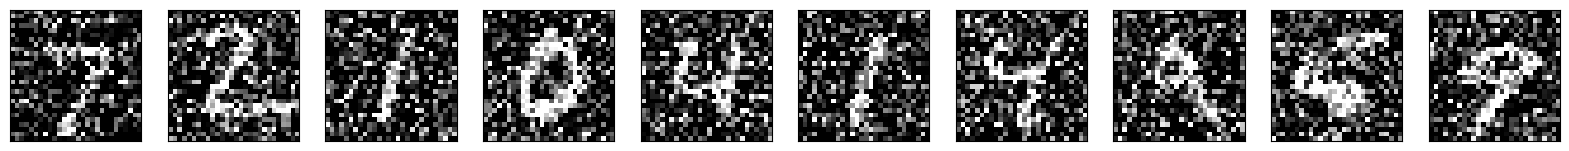

In [10]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## KERAS: sintax Model API

In [23]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,# Flatten, Reshape #I can consider flatten in reshape
from tensorflow.keras.models import Model
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', )(input_img)
x = MaxPooling2D((2, 2), )(x)
x = Conv2D(32, (3, 3), activation='relu', )(x)
encoded = Conv2D(4, (3, 3), activation='relu', )(x)
#with flaten before
#x = Flatten()(x)
#encoded = Dense(64, activation='relu',)(x)   #in this layer you compress the images, can change some values inside I can consider 12 instead of 4 encoded = Conv2D(12, (3, 3), activation='relu', )(x)
#with flatten is dense and I can do now reshaping
#x = Reshape((8,8,1))(encoded)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu',)(encoded) #with flatten is x instead of encoded
#x = Conv2D(32, (3, 3), activation='relu',)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid',padding='same' )(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_38 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 7744)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                495680    
                                                           

In [19]:
autoencoder.fit(x_train_noisy, x_train,   #give as input the noisy images and the original images
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test_noisy, x_test) #if we calculate also valid data we can understand if there is loss and overfitting
                #validation_data=(x_test_noisy, x_test), don't need since I don't have a target to evaluate
                )

Epoch 1/50
938/938 [==============================] - 6s 6ms/step - loss: 0.1669 - val_loss: 0.1674
Epoch 2/50
938/938 [==============================] - 10s 11ms/step - loss: 0.1670 - val_loss: 0.1654
Epoch 3/50
938/938 [==============================] - 9s 9ms/step - loss: 0.1668 - val_loss: 0.1659
Epoch 4/50
938/938 [==============================] - 9s 9ms/step - loss: 0.1667 - val_loss: 0.1656
Epoch 5/50
938/938 [==============================] - 5s 6ms/step - loss: 0.1667 - val_loss: 0.1666
Epoch 6/50
938/938 [==============================] - 6s 7ms/step - loss: 0.1666 - val_loss: 0.1663
Epoch 7/50
938/938 [==============================] - 5s 6ms/step - loss: 0.1666 - val_loss: 0.1656
Epoch 8/50
938/938 [==============================] - 6s 7ms/step - loss: 0.1664 - val_loss: 0.1671
Epoch 9/50
938/938 [==============================] - 5s 6ms/step - loss: 0.1665 - val_loss: 0.1663
Epoch 10/50
938/938 [==============================] - 6s 6ms/step - loss: 0.1663 - val_loss: 0.16

We wil show the noisy images and the coded images,
 so reconstruct

313/313 [==============================] - 1s 2ms/step


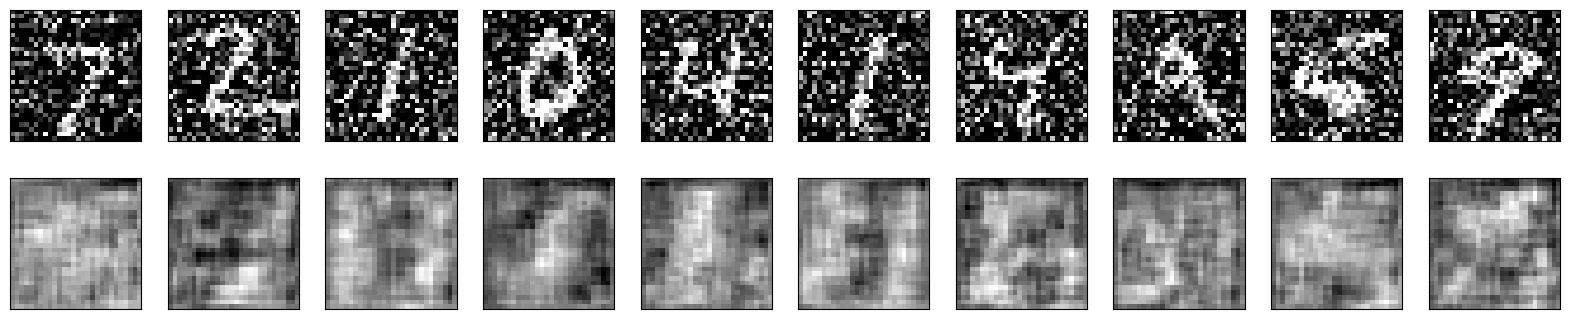

In [21]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))  #plot 10 images from noise images
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28)) #plot 10 images
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()